# Library import

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
# faster rcnn model이 포함된 library
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm


# for EDA
import matplotlib.pyplot as plt
import PIL
import torchvision.transforms as transforms
from PIL import ImageFont, ImageDraw, Image

# Dataset 생성

In [2]:
class CustomDataset(Dataset):
    '''
      data_dir: data가 존재하는 폴더 경로
      transforms: data transform (resize, crop, Totensor, etc,,,)
    '''

    def __init__(self, annotation, data_dir):
        super().__init__()
        self.data_dir = data_dir
        # coco annotation 불러오기 (coco API)
        self.coco = COCO(annotation)

    def __getitem__(self, index: int):
        
        image_id = self.coco.getImgIds(imgIds=index)

        image_info = self.coco.loadImgs(image_id)[0]
        
        image = cv2.imread(os.path.join(self.data_dir, image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        ann_ids = self.coco.getAnnIds(imgIds=image_info['id'])
        anns = self.coco.loadAnns(ann_ids)

        image = torch.tensor(image, dtype=torch.float32).permute(2,0,1)

        return image
    
    def __len__(self) -> int:
        return len(self.coco.getImgIds())

# inference function

In [3]:
def inference_fn(test_data_loader, model, device):
    outputs = []
    for images in tqdm(test_data_loader):
        # gpu 계산을 위해 image.to(device)
        images = list(image.to(device) for image in images)
        output = model(images)
        for out in output:
            outputs.append({'boxes': out['boxes'].tolist(), 'scores': out['scores'].tolist(), 'labels': out['labels'].tolist()})
    return outputs

# Main

In [4]:
def main():
    annotation = '../dataset/test.json' # annotation 경로
    data_dir = '../dataset' # dataset 경로
    test_dataset = CustomDataset(annotation, data_dir)
    score_threshold = 0.05
    check_point = './checkpoints/faster_rcnn_torchvision_checkpoints.pth' # 체크포인트 경로
    

    test_data_loader = DataLoader(
        test_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4
    )
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    
    # torchvision model 불러오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    num_classes = 11  # 10 class + background
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    model.load_state_dict(torch.load(check_point))
    model.eval()
    
    outputs = inference_fn(test_data_loader, model, device)
    prediction_strings = []
    file_names = []
    coco = COCO(annotation)
    
    return outputs
    

    # submission 파일 생성
    for i, output in enumerate(outputs):
        prediction_string = ''
        image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score > score_threshold: 
                # label[1~10] -> label[0~9]
                prediction_string += str(label-1) + ' ' + str(score) + ' ' + str(box[0]) + ' ' + str(
                    box[1]) + ' ' + str(box[2]) + ' ' + str(box[3]) + ' '
        prediction_strings.append(prediction_string)
        file_names.append(image_info['file_name'])
    submission = pd.DataFrame()
    submission['PredictionString'] = prediction_strings
    submission['image_id'] = file_names
    submission.to_csv('./faster_rcnn_torchvision_submission.csv', index=None)
    print(submission.head())

In [5]:
outputs = main()
print(len(outputs))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
cuda


 33%|███▎      | 202/609 [00:58<01:54,  3.55it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

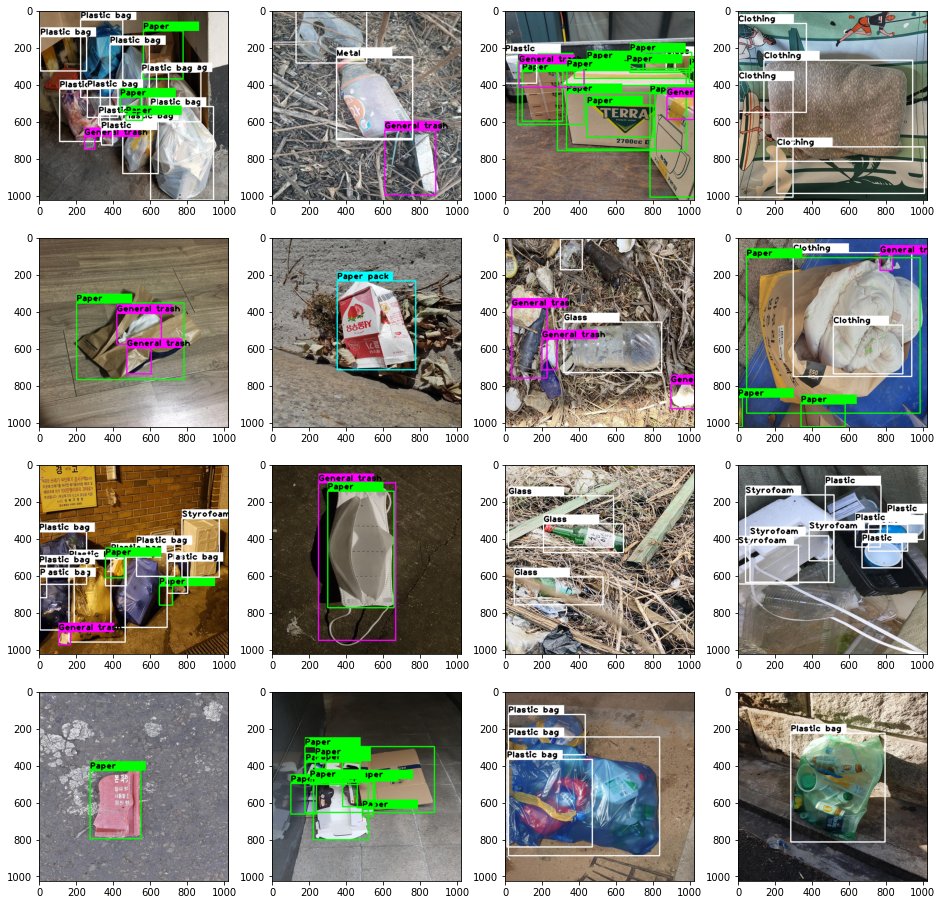

In [ ]:
# submission 파일 생성

annotation = '../dataset/test.json' # annotation 경로
coco = COCO(annotation)
score_threshold = 0.6
prediction_strings = []
file_names = []

class_name_list = ['General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic', 'Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
class_color_list = [(250,0,50), (0, 255, 0), (0, 180, 80), (185, 185, 185), (100, 100, 100), (200, 50, 150), (50, 150, 200), (50, 200, 150), (200, 200, 200), (255,255,255)]


plt.figure(figsize=(16,16))
for i, output in enumerate(outputs):
    if i < 16:
        prediction_string = ''
        image_info = coco.loadImgs(coco.getImgIds(imgIds=i))[0]
        
        image = cv2.imread(os.path.join('../dataset', image_info['file_name']))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
            if score > score_threshold: 
                # label[1~10] -> label[0~9]
                prediction_string += str(label-1) + ' ' + str(score) + ' ' + str(box[0]) + ' ' + str(
                    box[1]) + ' ' + str(box[2]) + ' ' + str(box[3]) + ' '
                        
                label_idx = label - 1
                cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), class_color_list[label_idx], 5)

                text = class_name_list[label_idx]    
                cv2.rectangle(image, (int(box[0]), int(box[1] - 50)), (int(box[0]) + 300, int(box[1])), class_color_list[label_idx], -1)
                cv2.putText(image, text, (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_PLAIN, 3, (0,0,0), 5, cv2.LINE_AA)
                
                
        prediction_strings.append(prediction_string)
        file_names.append(image_info['file_name'])

        plt.subplot(4, 4, i+1)
        plt.imshow(image)
        
plt.savefig('output.png', dpi=300, bbox_inches='tight')
    

In [ ]:
if __name__ == '__main__':
    main()